### Basics Imports

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO
    #level=logging.DEBUG
)
logger = logging.getLogger('__name__')
import numpy as np
import pandas as pd
import sys

### TensorNetworks imports

In [ ]:
sys.path.append("../")
import tensornetworks as tn
import tn_quantum_circuits as tnqc
import gates as gt

### Imports QLM

In [ ]:
import qat.lang.AQASM as qlm
from qat.qpus import PyLinalg
qpu_p = PyLinalg()
from qlm_stuff import proccess_qresults

## 1. Estado  Inicial

Vendrá dado por:

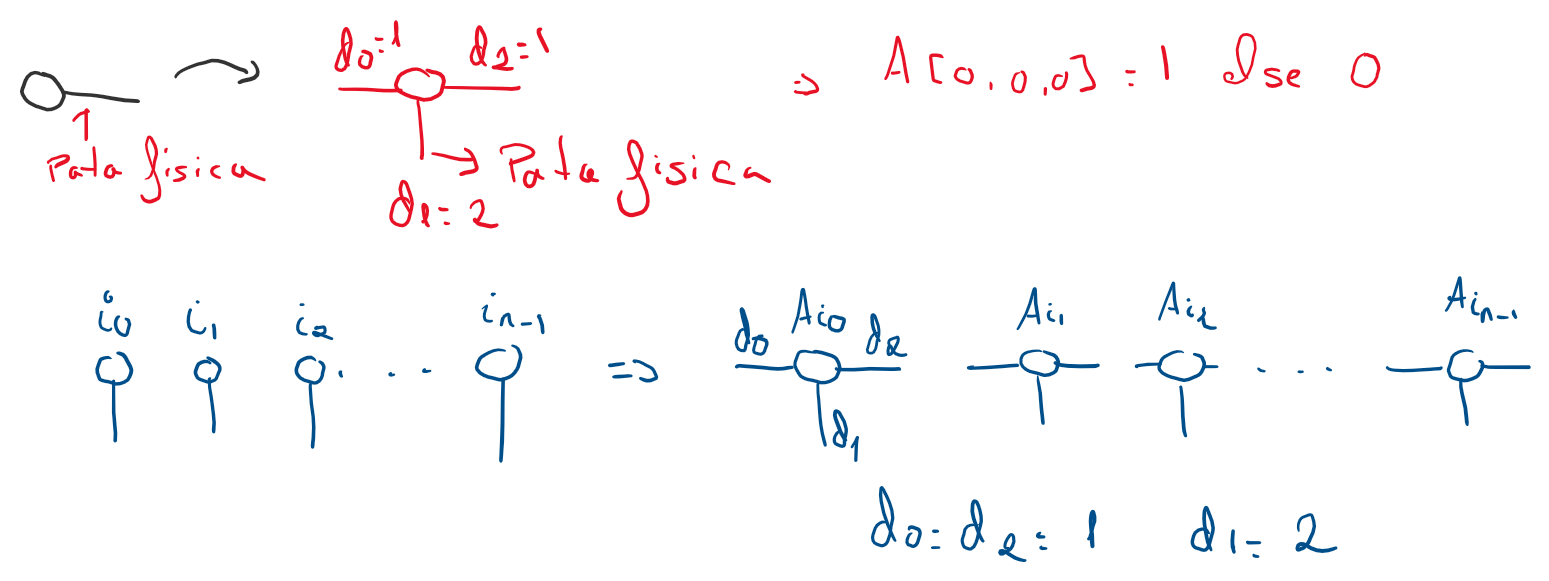

In [ ]:
nqubits = 5
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits

In [ ]:
final_tensor = tnqc.compose_mps(qubits_0)
final_tensor.shape

In [ ]:
pdf_zalo = tnqc.get_state_from_mps(qubits_0)

In [ ]:
pdf_zalo["Amplitude"]

## 2 Aplico Puertas Locales

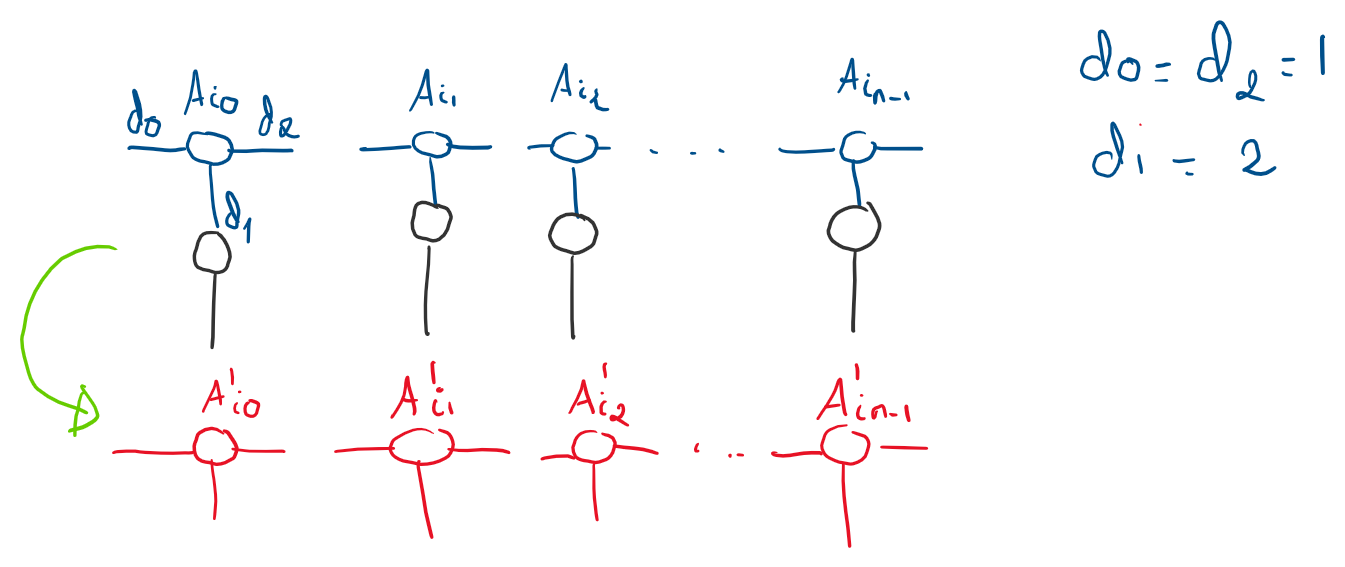

### 2.1 Haddamards

In [ ]:
# Apply Haddamard
qubits_h = tnqc.apply_local_gate(qubits_0, [gt.h_gate()] * nqubits)

In [ ]:
pdf_zalo = tnqc.get_state_from_mps(qubits_h)

In [ ]:
pdf_zalo

In [ ]:
def do_staff(nqubits):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.H, qbits[i])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   

In [ ]:
pdf, c= do_staff(nqubits)

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

### 2.2 X-Rotations

In [ ]:
angle0 = np.pi / 10.0
gates_x = [gt.x_rotation(angle0) for i in qubits_0]
qubits_x = tnqc.apply_local_gate(qubits_0, gates_x)
pdf_zalo = tnqc.get_state_from_mps(qubits_x)

In [ ]:
pdf_zalo

In [ ]:
def do_staff_x(nqubits, angle):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.RX(angle), qbits[i])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   

In [ ]:
pdf, c= do_staff_x(nqubits, angle0)

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

## 3. Aplico Puertas No Locales

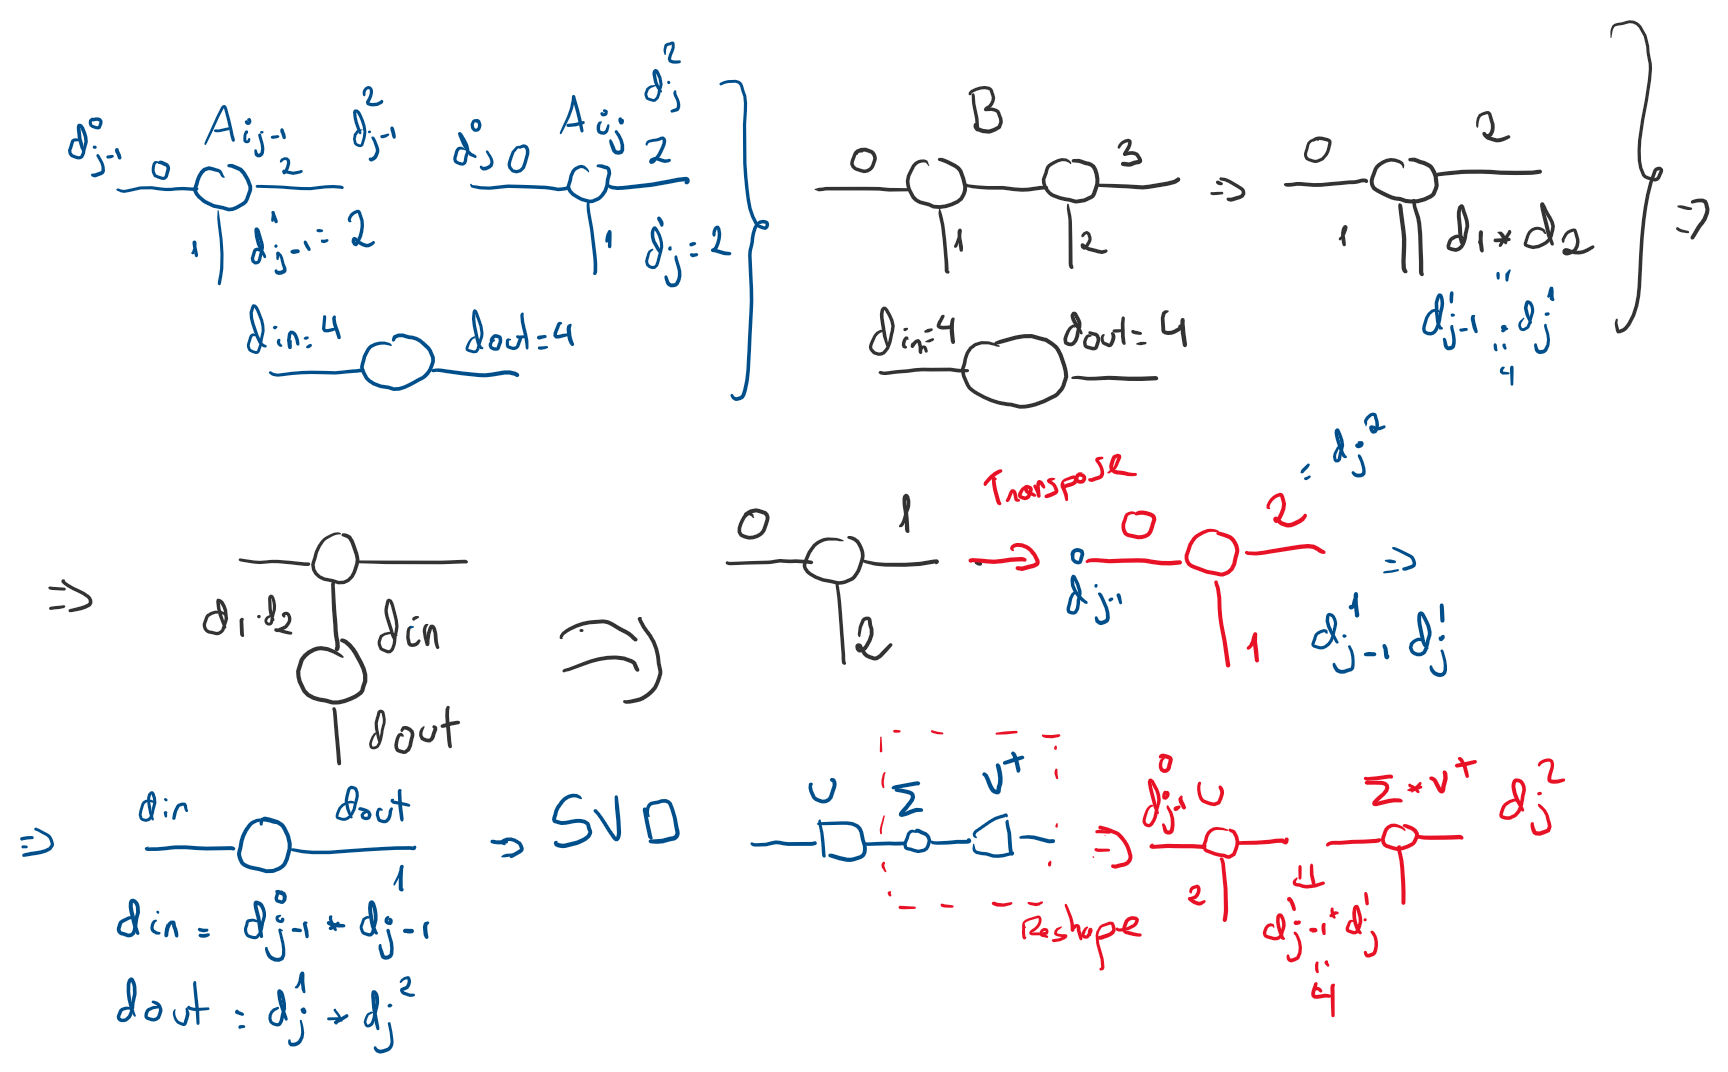

### 3.1 Rx + Non Local

In [ ]:
nqubits = 2
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits
angle0 = np.pi / 10.0
gates_x = [gt.x_rotation(angle0) for i in qubits_0]
qubits_x = tnqc.apply_local_gate(qubits_0, gates_x)
tensor_l, tensor_r = tnqc.apply_2qubit_gate(qubits_x[0], qubits_x[1], gt.controlz())

In [ ]:
pdf_zalo = tnqc.get_state_from_mps([tensor_l, tensor_r])

In [ ]:
pdf_zalo

In [ ]:
def do_staff_x_cz(angle):
    qprog = qlm.Program()
    qbits = qprog.qalloc(2)
    qprog.apply(qlm.RX(angle), qbits[0])
    qprog.apply(qlm.RX(angle), qbits[1])
    qprog.apply(qlm.Z.ctrl(), qbits[0], qbits[1])
    #qprog.apply(qlm.Z.ctrl(), qbits[1], qbits[0])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, 2)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   

In [ ]:
pdf, c= do_staff_x_cz(angle0)

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

### 3.2 H + Non local

In [ ]:
nqubits = 2
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits
angle0 = np.pi / 10.0
gates_h = [gt.h_gate() for i in qubits_0]
qubits_h = tnqc.apply_local_gate(qubits_0, gates_h)
tensor_l, tensor_r = tnqc.apply_2qubit_gate(qubits_h[0], qubits_h[1], gt.controlz())

In [ ]:
pdf_zalo = tnqc.get_state_from_mps([tensor_l, tensor_r])

In [ ]:
pdf_zalo

In [ ]:
def do_staff_h_cz():
    qprog = qlm.Program()
    qbits = qprog.qalloc(2)
    qprog.apply(qlm.H, qbits[0])
    qprog.apply(qlm.H, qbits[1])
    qprog.apply(qlm.Z.ctrl(), qbits[0], qbits[1])
    #qprog.apply(qlm.Z.ctrl(), qbits[1], qbits[0])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, 2)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   

In [ ]:
pdf, c= do_staff_h_cz()

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

## 4. Aplico Varias puertas NO-Locales

In [ ]:
def apply_2qubit_gates(qubits, gates):
    """
    Executes product of tensor with a gate
    -o-o-o-o-o-..o-o-
     |   |   |     |
    """
    new_qubits = [0 for i in qubits]
    left = qubits[0]
    for i in range(1, len(qubits)):
        right = qubits[i]
        gate = gates[i-1]
        #new_qubits[i-1], left = phase_change(left, right, gate)
        new_qubits[i-1], left = tnqc.apply_2qubit_gate(left, right, gate)

    new_qubits[-1], new_qubits[0] = tnqc.apply_2qubit_gate(
        left, new_qubits[0], gates[-1])
     #new_qubits[-1], new_qubits[0] = phase_change(left, new_qubits[0], gates[-1])
    return new_qubits

In [ ]:
nqubits = 5
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits
angle0 = np.pi / 10.0
gates_h = [gt.h_gate() for i in qubits_0]
qubits_h = tnqc.apply_local_gate(qubits_0, gates_h)

In [ ]:
#ent_gates = [controlz() for i in qubits_h[:-1]] + [None]
ent_gates = [gt.controlz() for i in qubits_h]

In [ ]:
qubits_ent = apply_2qubit_gates(qubits_h, ent_gates)

In [ ]:
pdf_zalo = tnqc.get_state_from_mps(qubits_ent)

In [ ]:
def do_staff_h_cz(nqubits):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.H, qbits[i])
    for i in range(nqubits-1):
        qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
    qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

In [ ]:
pdf, c= do_staff_h_cz(nqubits)

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

#### 4.2 R_x+ Entanglement

In [ ]:
nqubits = 5
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits
angle0 = np.pi / 10.0
gates_x = [gt.x_rotation(angle0) for i in qubits_0]
qubits_x = tnqc.apply_local_gate(qubits_0, gates_x)
ent_gates = [gt.controlz() for i in qubits_x]
qubits_ent = apply_2qubit_gates(qubits_x, ent_gates)
pdf_zalo = tnqc.get_state_from_mps(qubits_ent)

In [ ]:
def do_staff_rx_cz(nqubits, angle):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.RX(angle), qbits[i])
    for i in range(nqubits-1):
        qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
    qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

In [ ]:
pdf, c= do_staff_rx_cz(nqubits, angle0)

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

## 5. Parent Hamiltonian Ansatz

In [ ]:
%%time
nqubits = 15
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits
angle0 = np.pi / 10.0
gates_x = [gt.x_rotation(angle0) for i in qubits_0]
qubits_x = tnqc.apply_local_gate(qubits_0, gates_x)
ent_gates = [gt.controlz() for i in qubits_x]
qubits_ent = apply_2qubit_gates(qubits_x, ent_gates)
angle1 = np.pi / 5.0
gates_z = [gt.z_rotation(angle1) for i in qubits_ent]
qubits_z = tnqc.apply_local_gate(qubits_ent, gates_z)
pdf_zalo = tnqc.get_state_from_mps(qubits_z)

In [ ]:
def do_staff_rx_cz_rz(nqubits, angle0, angle1):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.RX(angle0), qbits[i])
    for i in range(nqubits-1):
        qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
    qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
    for i in range(nqubits):
        qprog.apply(qlm.RZ(angle1), qbits[i])    
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ  

In [ ]:
%%time
pdf, c= do_staff_rx_cz_rz(nqubits, angle0, angle1)

In [ ]:
%qatdisplay c

In [ ]:
np.isclose(pdf["Amplitude"], pdf_zalo["Amplitude"]).all()

In [ ]:
pdf_zalo

In [ ]:
a = controlz()

In [ ]:
a.shape

In [ ]:
a

In [ ]:
b = a.reshape((2, 2, 2, 2))

In [ ]:
b[1, 0, 1, 0]

In [ ]:
b

In [ ]:

step = step.reshape(np.prod(step.shape[:2]), np.prod(step.shape[2:]))
u_, s_, vh = svd(step, full_matrices=False)

In [ ]:
u_

In [ ]:
s_

In [ ]:
vh

In [ ]:
a = compose_mps(qubits_0)

In [ ]:
a = a.reshape(tuple([2 for i in range(nqubits)]))

In [ ]:
a.reshape((2**nqubits))

In [ ]:
pdf_zalo

In [ ]:
def do_staff(nqubits):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.H, qbits[i])
    for i in range(nqubits-1):
        qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
    #qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_p.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   

In [ ]:
pdf, c= do_staff(nqubits)

In [ ]:
%qatdisplay c

In [ ]:
pdf

In [ ]:
qubits_h[0]

In [ ]:
qubits_h[0][:,:,1]

In [ ]:
def compose_mps(mps, physical_leg = 1, left_leg = 0, right_leg = 2):
    """
    Given an input MPS it computes the final Tensor

    Parameters
    ----------

    mps : list
        list where each element is a rank-3 tensor that conforms de MPS

    Returns
    _______

    tensor : np.array
        numpy array with the correspondient tensor

    """
    
    if all([mps_.ndim == 3 for mps_ in mps[1:-1]]) == False:
        raise ValueError("All tensors except first and last MUST BE of rank-3")
    
    start_tensor = mps[0]
    end_tensor = mps[-1]
    
    if (start_tensor.ndim == 3) and (end_tensor.ndim == 3):
        # All tensors are rank-3 tensors even first and last one
        tensor = mps[0]
        #Train contraction
        for i in range(1, len(mps)-1):
            tensor = tn.contract_indices(tensor, mps[i], [tensor.ndim-1], [left_leg])
            
        # ----Tensor n-1----     Tensor n
        # - o - o - o -...- o ---c-- o - 
        # | |   |   |       |        | |
        # |____________________________|
        # c is for contraction.
        tensor = tn.contract_indices(tensor, mps[-1], [tensor.ndim-1, 0], [left_leg, right_leg])
    elif (start_tensor.ndim == 2) and (end_tensor.ndim == 2):
        # First and Last tensor are rank-2 tensors
        tensor = mps[0]
        for i in range(1, len(mps)):
            tensor = contract_indices(
                tensor, mps[i], [tensor.ndim-1], [left_leg])
    else:
        raise ValueError("First and Last tensor MUST BE rank-2 or ran-3 tensors")
        
    return tensor

In [ ]:
pdf_zalo = get_label_state(nqubits)
pdf_zalo["Amplitudes"] = pdf_zalo["States"].apply(lambda x: get_value(qubits_0, x))

In [ ]:
ansatz_qlm(3, 1)

In [ ]:
qubits_h = ph.apply_local_gate(qubits_0, [h_gate()] * nqubits)
#t01, t02 = ph.apply_2qubit_gate(qubits_h[0], qubits_h[1], ph.phasechange_gate())

In [ ]:
step = tn.contract_indices(qubits_h[0], ph.phasechange_gate(), [2], [0])
step = tn.contract_indices(step, qubits_h[1], [2], [0])

In [ ]:
step

In [ ]:
step[:,:,1]

In [ ]:
qubits_h[0]

In [ ]:
step

In [ ]:
pdf_zalo = get_label_state(len(qubits_h))

In [ ]:
pdf_zalo["Amplitudes"] = pdf_zalo["States"].apply(lambda x: get_value([t01, t02], x))

In [ ]:
t01.shape

In [ ]:
t02.shape

In [ ]:
pdf_zalo

In [ ]:
def get_value(qubits, num):
    tensor = qubits[0][:,num[0],:]
    shapes = tensor.shape
    print(shapes)
    tensor = tensor.reshape(shapes[0], shapes[1])
    print(tensor.shape)
    for t, i in zip(qubits[1:], num[1:]):
        step = t[:, i, :]
        print(step.shape)
        step = step.reshape(step.shape[0], step.shape[1])
        tensor = tensor @ step.conj()
    return np.trace(tensor)

In [ ]:
get_value([t01, t02], [1,1])

In [ ]:
t01[:, 1, :] @ t02[:, 1, :]

In [ ]:
t01[:, 1, :]

In [ ]:
t02[:, 1, :]

In [ ]:
qubits_h[1]

In [ ]:
qubits_h[0]

In [ ]:
pdf

In [ ]:
pdf_zalo

In [ ]:
def compose_mps(mps, physical_leg = 1, left_leg = 0, right_leg = 2):
    """
    Given an input MPS it computes the final Tensor

    Parameters
    ----------

    mps : list
        list where each element is a rank-3 tensor that conforms de MPS

    Returns
    _______

    tensor : np.array
        numpy array with the correspondient tensor

    """
    
    if all([mps_.ndim == 3 for mps_ in mps[1:-1]]) == False:
        raise ValueError("All tensors except first and last MUST BE of rank-3")
    
    start_tensor = mps[0]
    end_tensor = mps[-1]
    
    if (start_tensor.ndim == 3) and (end_tensor.ndim == 3):
        # All tensors are rank-3 tensors even first and last one
        tensor = mps[0]
        #Train contraction
        for i in range(1, len(mps)-1):
            tensor = tn.contract_indices(tensor, mps[i], [tensor.ndim-1], [left_leg])
            
        # ----Tensor n-1----     Tensor n
        # - o - o - o -...- o ---c-- o - 
        # | |   |   |       |        | |
        # |____________________________|
        # c is for contraction.
        tensor = tn.contract_indices(tensor, mps[-1], [tensor.ndim-1, 0], [left_leg, right_leg])
    elif (start_tensor.ndim == 2) and (end_tensor.ndim == 2):
        # First and Last tensor are rank-2 tensors
        tensor = mps[0]
        for i in range(1, len(mps)):
            tensor = contract_indices(
                tensor, mps[i], [tensor.ndim-1], [left_leg])
    else:
        raise ValueError("First and Last tensor MUST BE rank-2 or ran-3 tensors")
        
    return tensor


In [ ]:
# Apply Haddamard
qubits_h = ph.apply_local_gate(qubits_0, [h_gate()] * nqubits)
gates = [ph.phasechange_gate()] * (len(qubits_h)-1) + [None]
qubits_e = ph.apply_2qubit_gates(qubits_h, gates)
pdf_zalo = get_label_state(len(qubits_e))
pdf_zalo["Amplitudes"] = pdf_zalo["States"].apply(lambda x: get_value(qubits_e, x))